In [2]:
import os
from pathlib import Path

import cv2 as cv
import matplotlib
import numpy as np
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from ultralytics import YOLO

from utils.edge import fill_rotate, get_rotation_angle, gum_jaw_separation
from utils.general import integral_intensity_projection
from utils.preprocess import rotate_point
from utils.shortcut import get_fake_result
from utils.yolo import get_teeth_ROI

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

% matplotlib inline


In [3]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


def delete_value_in_1d_np(np_array, target_element):
    idxes = np.where(np_array == target_element)[0]
    return np.delete(np_array, idxes)


YOLO_model_dir = Path(os.getenv('YOLO_MODEL_DIR'))
# data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'
data_dir = Path(os.getenv('DATASET_DIR')) / 'DENTEX CHALLENGE 2023'
data_dir


PosixPath('/Users/lucyxu/PycharmProjects/datasets/DENTEX CHALLENGE 2023')

In [4]:
model = YOLO(YOLO_model_dir / '8-bound-v8.pt')

model


In [5]:
from utils.data import DentexDataset

dataset = DentexDataset(root_dir=data_dir)

len(dataset)


634

In [6]:
plt.gray()

# image_paths = list(data_dir.glob('00008026.jpg'))
# image_paths = list(data_dir.glob('00006145.jpg'))
# image_paths = list(data_dir.glob('*.jpg'))
image_paths = dataset.img_paths

image_path = image_paths[0]

image_path.name


'train_172.png'

<Figure size 432x288 with 0 Axes>

In [49]:
class ImageEdge:
    tooth_number_dict = {
        'upper': {
            'left': ['17', '13'],
            'middle': ['13', '23'],
            'right': ['23', '27'],
        },
        'lower': {
            'left': ['47', '43'],
            'middle': ['43', '33'],
            'right': ['33', '37'],
        },
    }

    zooming_margin = 30
    MINIMUM_TOOTH_WIDTH = 30

    def plot_something(self, plot_name, **kwarg):
        if plot_name == 'find_gap_in_roi.im_peak_gap':
            ver = kwarg['ver']
            gaps = kwarg['gaps']
            peaks = kwarg['peaks']
            new_gaps = kwarg['new_gaps']
            side_gaps = kwarg['side_gaps']
            properties = kwarg['properties']
            im_zooming = kwarg['im_zooming']

            gaps_flag = kwarg['gaps_flag']

            # Plot
            fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
            axes[0].imshow(im_zooming, aspect='auto')

            axes[1].plot(ver)
            for gap in side_gaps[1:3]:
                axes[1].axvline(gap[0], color='purple')
            if gaps_flag:
                for i, gap in enumerate(gaps):
                    axes[1].axvline(gap[0], color='red')
            for i, gap in enumerate(new_gaps):
                axes[1].axvline(gap[0], color='green')
            axes[1].plot(peaks, ver[peaks], 'x')
            plt.vlines(x=peaks, ymin=ver[peaks], ymax=ver[peaks] + properties["prominences"], color="C1")
            plt.hlines(y=properties["width_heights"] * -1, xmin=properties["left_ips"], xmax=properties["right_ips"],
                       color="C1")

            plt.show()

    def __init__(self, image_path, model=None, yolov8=False):
        self.im_global = cv.imread(str(image_path), cv.IMREAD_GRAYSCALE)

        self.image_path = image_path
        self.filename = image_path.stem

        # Set up roi
        if model:
            results = model(self.image_path)
        else:
            results = get_fake_result(self.image_path)

        self.template_points = {
            'upper': [],
            'lower': []
        }

        teeth_roi = get_teeth_ROI(results, yolov8=yolov8)
        self.teeth_roi_images = teeth_roi['images'][self.filename]
        self.split_teeth = teeth_roi['split_teeth'][self.filename]

        for number, split_tooth in self.split_teeth.items():
            tooth_im = cv.cvtColor(split_tooth['crop_image'], cv.COLOR_RGBA2GRAY)
            number = int(number)

            split_tooth['crop_image'] = tooth_im
            split_tooth['image_rotated'] = tooth_im
            split_tooth['xyxy'] = split_tooth['xyxy'].int().numpy().squeeze()
            # TODO Get the theta from the tooth not the region.
            split_tooth['angle'] = 0

            split_tooth['flag'] = 'upper' if number // 10 < 3 else 'lower'

        self.set_up_roi()
        self.find_gap_in_roi()
        self.get_tooth_bounding_by_gap_rotated()
        self.get_tooth_bounding_by_gap()

    def set_up_roi(self):
        for target_roi in self.teeth_roi_images:
            target_roi['image'] = cv.cvtColor(target_roi['image'], cv.COLOR_RGBA2GRAY)

            flag = target_roi['flag']
            tooth_position = target_roi['tooth_position']
            source = target_roi['image']

            theta = get_rotation_angle(source, flag=flag, tooth_position=tooth_position)
            source_rotated = fill_rotate(self.im_global, target_roi['xyxy'], theta)
            _, jaw_sep_pos, _, _ = gum_jaw_separation(source_rotated, flag, margin=0)
            jaw_sep_line = np.vstack([[0, jaw_sep_pos], [10, jaw_sep_pos]])
            jaw_sep_line_recover = rotate_point(theta, source.shape, jaw_sep_line, recovery=True)

            target_roi['image_rotated'] = source_rotated
            target_roi['angle'] = theta
            target_roi['jaw_pos_rotated'] = jaw_sep_pos
            target_roi['jaw_line'] = jaw_sep_line_recover

            for number in self.tooth_number_dict[flag][tooth_position]:
                split_tooth = self.split_teeth[number]

                if theta != 0:
                    split_tooth['angle'] = theta
                    split_tooth['image_rotated'] = fill_rotate(self.im_global, split_tooth['xyxy'], theta)

        for number, split_tooth in self.split_teeth.items():
            theta = split_tooth['angle']
            im_tooth = split_tooth['crop_image']
            im_tooth_rotated = split_tooth['image_rotated']
            xyxy_tooth = split_tooth['xyxy']
            flag = split_tooth['flag']

            h, w = im_tooth_rotated.shape

            gaps = self.find_global_gap_by_tooth(split_tooth)
            self.template_points[flag].append(gaps[0])
            self.template_points[flag].append(gaps[1])

            local_gaps = gaps - xyxy_tooth[:2]

            split_tooth['gaps'] = local_gaps

            # plt.imshow(im_tooth_rotated)
            # plt.scatter(*local_gaps_rotated[0])
            # plt.scatter(*local_gaps_rotated[1])
            # plt.show()

        # plt.imshow(self.im_global)
        # for i in self.template_points['upper']:
        #     plt.axline(*i[:2])
        #     plt.axline(*i[2:])
        # plt.show()

        for flag in ('upper', 'lower'):
            points = self.template_points[flag]
            points = np.vstack(points)
            points = points[np.argsort(points[:, 0])]

            self.template_points[flag] = points

    def sort_template_point(self):
        for flag in ('upper', 'lower'):
            points = self.template_points[flag]
            points = np.vstack(points)
            points = points[np.argsort(points[:, 0])]

            self.template_points[flag] = points

    @staticmethod
    def find_local_gap_by_tooth(im_tooth, flag):
        """
        This function finds the local minima of an image of a tooth.
        Args:
            im_tooth: A 2-D array representing an image of a tooth
            flag: A flag denote the tooth is in upper or lower

        Returns:
            gaps: The location of the local minima in an array
            gaps_intensity: The intensity of the local minima in the image
        """
        # Get the height and width of the tooth
        im_tooth = cv.equalizeHist(im_tooth)
        h, w = im_tooth.shape
        gum_pos = h / 5 * 3 if flag == 'upper' else h / 5 * 2
        gum_pos = int(gum_pos)
        margin = 40
        radius = 6

        im_tooth_zoom = im_tooth[gum_pos - margin:gum_pos + margin, :]

        # Get the integral intensity projection of the tooth
        hor, ver = integral_intensity_projection(im_tooth_zoom)

        # Get the inverse of the ver projection
        ver_inverse = ver.max() - ver
        hor_inverse = hor.max() - hor

        # Find the peaks of the ver_inverse
        peaks, _ = find_peaks(ver_inverse, height=0)
        hor_peaks, _ = find_peaks(hor_inverse, height=0)

        gum_pos_fix = hor_peaks[np.argmin(hor[hor_peaks])] + (gum_pos - margin)

        # Get the peaks from left and right
        peaks_left = peaks[peaks < w / 2]
        peaks_right = peaks[peaks > w / 2]

        # Get the local minima from the left and right peaks
        left_gap_pose = peaks_left[ver[peaks_left].argmin()]
        right_gap_pose = peaks_right[ver[peaks_right].argmin()]

        left_gap_pose += max(radius - left_gap_pose, 0)
        right_gap_pose -= max(radius - (w - right_gap_pose), 0)

        gap_poses = np.array((left_gap_pose, right_gap_pose))

        gaps = np.array([
            [gap_poses[0], gum_pos_fix],
            [gap_poses[1], gum_pos_fix]
        ])

        mask = np.zeros((h, w), im_tooth.dtype)
        left_mask = cv.circle(mask, gaps[0], radius, 255, -1)
        mask = np.zeros((h, w), im_tooth.dtype)
        right_mask = cv.circle(mask, gaps[1], radius, 255, -1)

        left_im_masked = np.bitwise_and(im_tooth, left_mask)
        right_im_masked = np.bitwise_and(im_tooth, right_mask)

        gaps_intensity = [np.sum(left_im_masked), np.sum(right_im_masked)]

        # Plot
        # fig, axes = plt.subplots(nrows=1, ncols=2)
        #
        # axes[0].imshow(im_tooth)
        # axes[0].scatter(*gaps[0], s=radius ** 2)
        # axes[0].scatter(*gaps[1], s=radius ** 2)
        #
        # index = range(gum_pos - margin, gum_pos + margin)
        # axes[1].plot(hor, index)
        # axes[1].plot(hor[hor_peaks], hor_peaks + (gum_pos - margin), 'x')
        # axes[1].set_ylim(h, 0)
        #
        # plt.show()

        gap_lines = []
        for gap_pos in gap_poses:
            gap_lines.append([gap_pos, 0])
            gap_lines.append([gap_pos, h])
        gap_lines = np.array(gap_lines)

        return gaps, gap_lines, gaps_intensity

    # TODO make sure the gap distance in normal distance
    def find_global_gap_by_tooth(self, split_tooth):
        tooth_im = split_tooth['crop_image']
        tooth_im_rotated = split_tooth['image_rotated']

        theta = split_tooth['angle']
        tooth_xyxy = split_tooth['xyxy']
        flag = split_tooth['flag']

        # Find gap beside tooth
        gaps_r, gap_lines_r, gaps_intensity_r = self.find_local_gap_by_tooth(tooth_im_rotated, flag)
        gaps_o, gap_lines_o, gaps_intensity_o = self.find_local_gap_by_tooth(tooth_im, flag)

        # Get gap line global
        gap_matrix_r = rotate_point(theta, tooth_im.shape, gaps_r, recovery=True)
        gap_matrix_r = gap_matrix_r + tooth_xyxy[:2]

        ## Recovery w/o theta
        gap_matrix_o = gaps_o + tooth_xyxy[:2]

        gap_matrix = gap_matrix_r.copy()
        left_gap_flag = gaps_intensity_r[0] < gaps_intensity_o[0]
        right_gap_flag = gaps_intensity_r[1] < gaps_intensity_o[1]
        gap_matrix[0] = gap_matrix_r[0] if left_gap_flag else gap_matrix_o[0]
        gap_matrix[1] = gap_matrix_r[1] if right_gap_flag else gap_matrix_o[1]

        # Plot
        # plt.imshow(self.im_global)
        # plt.scatter(*gap_matrix[0])
        # plt.scatter(*gap_matrix[1])
        # plt.show()
        #
        # gaps = gap_matrix - tooth_xyxy[:2]
        # plt.imshow(tooth_im)
        # plt.scatter(*gaps[0])
        # plt.scatter(*gaps[1])
        # plt.show()

        return gap_matrix

    def find_gap_in_roi(self):
        for target_roi in self.teeth_roi_images:
            flag = target_roi['flag']
            tooth_position = target_roi['tooth_position']
            xyxy = target_roi['xyxy'].numpy()
            theta = target_roi['angle']
            im = target_roi['image']
            im_r = target_roi['image_rotated']
            jaw_pos = target_roi['jaw_pos_rotated']

            h, w = im_r.shape

            # Getting the gap beside pivot tooth
            side_gaps = self.side_gaps_init(flag, im, theta, tooth_position, xyxy)

            # Getting first gap pos by side gap
            new_gaps = self.get_init_inside_gap(h, im_r, jaw_pos, side_gaps, tooth_position, w)

            # Fix the gap pos by peak of vertical integral
            y_min = np.min(new_gaps[:, 1]).astype(int)
            y_max = np.max(new_gaps[:, 1]).astype(int)

            if flag == 'upper':
                y1 = y_min
                y2 = jaw_pos
                y_new = y_min
            else:
                y1 = jaw_pos
                y2 = y_max
                y_new = y_max

            im_zooming = im_r[y1:y2, :]
            im_zooming = cv.equalizeHist(im_zooming)

            # new_gaps, peaks, properties, ver = self.gap_pos_fix_1(new_gaps, im_zooming, side_gaps, y_new)

            # Remove gap make the tooth width abnormal
            # new_gaps = self.gap_pos_fix_2(new_gaps, side_gaps, tooth_position)

            # Plot
            # self.plot_something('find_gap_in_roi.im_peak_gap',
            #                     ver=ver,
            #                     gaps=gaps,
            #                     peaks=peaks,
            #                     new_gaps=new_gaps,
            #                     side_gaps=side_gaps,
            #                     im_zooming=im_zooming,
            #                     properties=properties,
            #                     gaps_flag=False)

            # Transform back to global
            gaps_rotated = np.concatenate((side_gaps[:2], new_gaps, side_gaps[2:]), axis=0)
            target_roi['gaps_rotated'] = gaps_rotated
            target_roi['gaps'] = rotate_point(target_roi['angle'], target_roi['image'].shape, gaps_rotated,
                                              recovery=True)

            # gaps_global = gaps.copy()
            gaps_global = new_gaps.copy()
            gaps_global = rotate_point(target_roi['angle'], target_roi['image'].shape, gaps_global, recovery=True)
            gaps_global += xyxy[:2]

            self.template_points[flag] = np.concatenate((self.template_points[flag], gaps_global), axis=0)

            # plt.imshow(target_roi['image_rotated'])
            # for i in side_gaps:
            #     plt.scatter(*i)
            # for i in new_gaps:
            #     plt.scatter(*i, color='green')
            # plt.show()

            # break
        self.sort_template_point()

    def gap_pos_fix_2(self, new_gaps, side_gaps, tooth_position):
        temp_all_gaps = np.concatenate((side_gaps[:2], new_gaps, side_gaps[2:]), axis=0)
        if tooth_position == 'middle':
            # Finding remove which gap can get the minimum std
            same_type_tooth_gap = temp_all_gaps[1:-1, 0]
            init_tooth_widths = np.diff(same_type_tooth_gap)
            tooth_widths = init_tooth_widths
            # 15 is base on the experience
            if np.std(tooth_widths) > 15:
                length = len(tooth_widths)
                idx_std_pair = []
                # Get the std after deleting each gap after listing all the gaps that can be deleted
                for j in range(1, length):
                    gap_idxes = np.arange(0, length + 1)
                    gap_idxes = np.delete(gap_idxes, j)
                    deleted_gaps = same_type_tooth_gap[gap_idxes]
                    idx_std_pair.append([j, np.std(np.diff(deleted_gaps))])
                idx_std_pair = np.array(idx_std_pair)

                target_gap_idx = np.argmin(idx_std_pair[:, 1]).astype(int)
                if idx_std_pair[target_gap_idx][1] < 15:
                    new_gaps = np.delete(new_gaps, target_gap_idx, axis=0)
        return new_gaps

    def gap_pos_fix_1(self, gaps, im_zooming, side_gaps, y_new):
        x1 = side_gaps[1][0] + 30
        x2 = side_gaps[2][0] - 30
        _, ver = integral_intensity_projection(im_zooming)
        standardize_ver = (ver - np.mean(ver)) / np.std(ver)
        ver = standardize_ver
        peaks, properties = find_peaks(ver * -1, height=0, width=0, prominence=0.3, rel_height=0.25)
        dist_gap_peak = []
        for idx_peak, peak in enumerate(peaks):
            if peak < x1 or peak > x2:
                continue

            for idx_gap, gap in enumerate(gaps):
                dist = np.abs(gap[0] - peak)
                dist_gap_peak.append([dist, idx_gap, idx_peak])
        dist_gap_peak = np.array(dist_gap_peak)
        # FIXME edge case: dist_gap_peak empty
        dist_sorted_idx = np.argsort(dist_gap_peak[:, 0])
        dist_gap_peak = dist_gap_peak[dist_sorted_idx].astype(int)
        wait_gaps = np.unique(dist_gap_peak[:, 1])
        wait_peaks = np.unique(dist_gap_peak[:, 2])
        new_gaps = []
        for dist, idx_gap, idx_peak in dist_gap_peak:
            if idx_gap not in wait_gaps:
                continue
            if idx_peak not in wait_peaks:
                continue

            peak_width = properties['widths'][idx_peak]

            if peak_width > 30:
                # TODO label missing here
                missing_left = properties['left_ips'][idx_peak]
                missing_right = properties['right_ips'][idx_peak]
                new_gaps.append([missing_left, y_new])
                new_gaps.append([missing_right, y_new])
            else:
                new_gaps.append((peaks[idx_peak], y_new))

            # wait_gap.append(idx_gap)
            # wait_peak.append(idx_peak)
            wait_gaps = delete_value_in_1d_np(wait_gaps, idx_gap)
            wait_peaks = delete_value_in_1d_np(wait_peaks, idx_peak)
        new_gaps = np.array(new_gaps)
        new_gaps = new_gaps[np.argsort(new_gaps[:, 0])]
        return new_gaps, peaks, properties, ver

    @staticmethod
    def get_init_inside_gap(h, im_r, jaw_pos, side_gaps, tooth_position, w):
        if tooth_position == 'middle':
            tooth_step = (side_gaps[2] - side_gaps[1]) / 4
            gaps = np.array([side_gaps[1] + tooth_step * i for i in range(1, 4)])
        else:
            # TODO Add factor here
            left_size = (side_gaps[1] - side_gaps[0])
            right_size = (side_gaps[3] - side_gaps[2])

            points = np.array([side_gaps[1] + left_size, side_gaps[2] - right_size])

            distance = np.abs(points[0][0] - points[1][0])

            # 30 is the minimum width of tooth
            if distance > 30:
                gaps = np.array(points)
            else:
                thickness = 3

                y = np.max(points[:, 1])
                points[:, 1] = y

                mask = np.zeros((h, w), im_r.dtype)
                left_mask = cv.line(mask, points[0], (points[0][0], jaw_pos), 255, thickness)
                mask = np.zeros((h, w), im_r.dtype)
                right_mask = cv.line(mask, points[1], (points[1][0], jaw_pos), 255, thickness)

                left_im_masked = np.bitwise_and(im_r, left_mask)
                right_im_masked = np.bitwise_and(im_r, right_mask)

                gaps_intensity = np.array([np.sum(left_im_masked), np.sum(right_im_masked)])
                gaps = np.array([points[np.argmin(gaps_intensity)]])
        return gaps

    def side_gaps_init(self, flag, im, theta, tooth_position, xyxy):
        left_number, right_number = self.tooth_number_dict[flag][tooth_position]

        left_tooth = self.split_teeth[left_number]
        left_gaps = left_tooth['gaps'].copy()
        left_gaps += left_tooth['xyxy'][:2]

        right_tooth = self.split_teeth[right_number]
        right_gaps = right_tooth['gaps'].copy()
        right_gaps += right_tooth['xyxy'][:2]

        side_gaps = np.vstack([left_gaps, right_gaps])
        side_gaps -= xyxy[:2]
        side_gaps = rotate_point(theta, im.shape, side_gaps)

        return side_gaps

    def get_tooth_bounding_by_gap_rotated(self):
        for teeth_roi_image in self.teeth_roi_images:
            jaw_pos = teeth_roi_image['jaw_pos_rotated']
            im_rotated = teeth_roi_image['image_rotated']
            gaps_rotated = teeth_roi_image['gaps_rotated']

            boxes = []
            for i in range(len(gaps_rotated) - 1):
                x1 = gaps_rotated[i][0]
                x2 = gaps_rotated[i + 1][0]
                y2 = jaw_pos

                crown_size = max(y2 - gaps_rotated[i][1], y2 - gaps_rotated[i + 1][1])
                y1 = y2 - (crown_size / 2 * 5)

                y1, y2 = (y1, y2) if y1 < y2 else (y2, y1)
                box = np.array([x1, y1, x2, y2])
                boxes.append(box)

            boxes = np.array(boxes)
            teeth_roi_image['boxes_rotated'] = boxes

            teeth_roi_image['boxes_cropped'] = []
            for box in boxes:
                x1, y1, x2, y2 = box.astype(int)

                x1 = 0 if x1 < 0 else x1
                x2 = 0 if x2 < 0 else x2
                y1 = 0 if y1 < 0 else y1
                y2 = 0 if y2 < 0 else y2

                boxes_cropped = im_rotated[y1:y2, x1:x2]

                teeth_roi_image['boxes_cropped'].append(boxes_cropped)

            # plt.imshow(im_rotated)
            # for i in boxes:
            #     show_box(i, plt.gca())
            # plt.show()

    def get_tooth_bounding_by_gap(self):
        for teeth_roi_image in self.teeth_roi_images:
            jaw_pos = teeth_roi_image['jaw_pos_rotated']
            im_rotated = teeth_roi_image['image_rotated']
            gaps_rotated = teeth_roi_image['gaps_rotated']

            im = teeth_roi_image['image']
            gaps = teeth_roi_image['gaps']
            jaw_line = teeth_roi_image['jaw_line']

            def get_y(x):
                """Returns the y-coordinate on the line that passes through point1 and point2, given an x-coordinate."""
                point1 = jaw_line[0]
                point2 = jaw_line[1]

                slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
                y = slope * x + point1[1]
                return y

            boxes = []
            for i in range(len(gaps_rotated) - 1):
                x1 = gaps[i][0]
                x2 = gaps[i + 1][0]
                xm = (x2 + x1) // 2
                y2 = get_y(xm)

                crown_size = max(y2 - gaps[i][1], y2 - gaps[i + 1][1])
                y1 = y2 - (crown_size / 2 * 5)

                y1, y2 = (y1, y2) if y1 < y2 else (y2, y1)
                box = np.array([x1, y1, x2, y2])
                boxes.append(box)

            boxes = np.array(boxes)
            teeth_roi_image['boxes'] = boxes

            # plt.imshow(im)
            # for i in boxes:
            #     show_box(i, plt.gca())
            # plt.show()


image_edge = ImageEdge(image_path, model=model, yolov8=True)



image 1/1 /Users/lucyxu/PycharmProjects/datasets/DENTEX CHALLENGE 2023/training_data/quadrant_enumeration/xrays/train_172.png: 320x640 1 13, 1 17, 1 23, 1 27, 1 33, 2 37s, 1 43, 1 47, 55.9ms
Speed: 1.4ms preprocess, 55.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


In [8]:
image_edge.teeth_roi_images[0].keys()


dict_keys(['flag', 'tooth_position', 'org_file_name', 'offset', 'padding', 'image', 'xyxy', 'image_rotated', 'angle', 'jaw_pos_rotated', 'gaps_rotated', 'boxes_rotated', 'boxes_cropped'])

In [9]:
np.delete(np.arange(0, 3), 2)


array([0, 1])

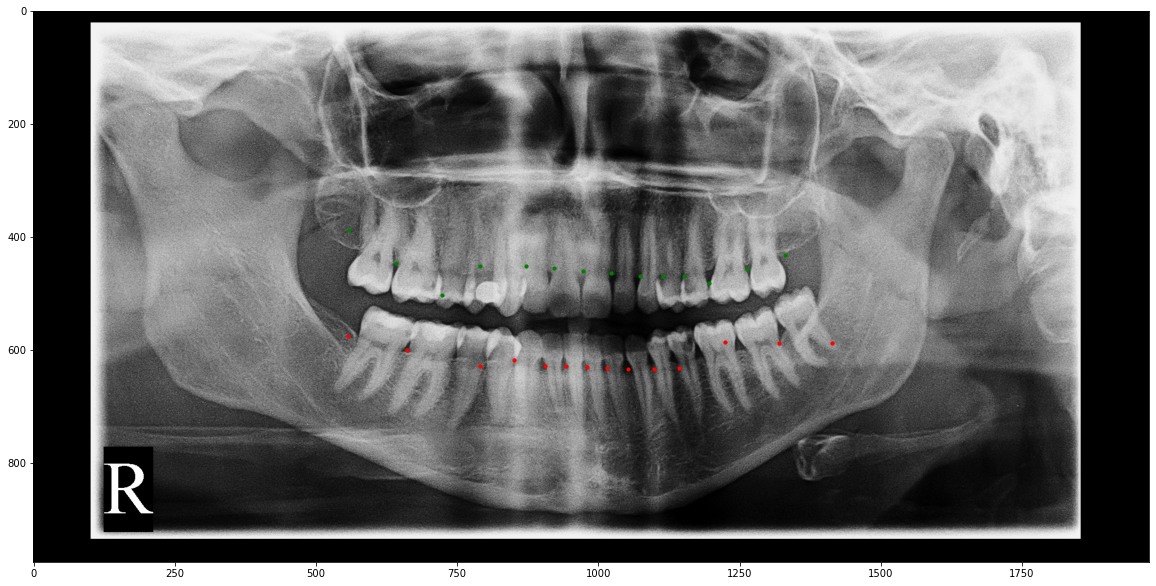

In [38]:
b = image_edge.template_points

plt.figure(figsize=(20, 20))
plt.imshow(image_edge.im_global)
for i in b['upper']:
    plt.scatter(*i, color='green', s=10)
for i in b['lower']:
    plt.scatter(*i, color='red', s=10)
plt.show()


[[      -13.5      162.25          81       257.5]
 [         52      162.25          50       257.5]
 [      102.5      167.25          51       247.5]
 [        153       173.5          50         235]
 [      203.5      179.75          51       222.5]
 [        249         186          40         210]]


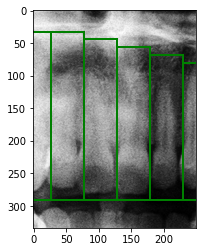

In [39]:
def xyxy2xywh(xyxy):
    x1, y1, x2, y2 = xyxy

    x = (x1 + x2) / 2
    y = (y1 + y2) / 2
    w = np.abs(x1 - x2)
    h = np.abs(y1 - y2)

    return np.array([x, y, w, h])


b = image_edge.teeth_roi_images[1]
boxes = b['boxes_rotated']
a = np.array([xyxy2xywh(i) for i in boxes])

print(a)

plt.imshow(b['image_rotated'])
for i in b['boxes_rotated']:
    show_box(i, plt.gca())
plt.show()


In [52]:
b = image_edge.teeth_roi_images[1]
boxes = b['boxes']

print(boxes)

image_edge.image



[[        -54        33.5          27         291]
 [         27        33.5          77         291]
 [         77        43.5         128         291]
 [        128          56         178         291]
 [        178        68.5         229         291]
 [        229          81         269         291]]


AttributeError: 'ImageEdge' object has no attribute 'image'